In [23]:
# 📦 Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [35]:
# 📊 Load dataset
df = pd.read_csv("Downloads/triage.csv")
print("Initial shape:", df.shape)

# 🔧 Convert vital sign columns to numeric
vital_cols = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
for col in vital_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ❌ Drop rows with missing acuity or chief complaint
df.dropna(subset=['acuity', 'chiefcomplaint'], inplace=True)

# 🏷️ Map acuity numbers to labels
acuity_map = {1: 'Critical', 2: 'Moderate', 3: 'Low'}
df['acuity_label'] = df['acuity'].map(acuity_map)

# ✅ Keep only relevant features for modelling
df = df[['chiefcomplaint'] + vital_cols + ['acuity_label']]

# ❌ Drop any remaining NaNs
df.dropna(inplace=True)

# 📈 Display cleaned dataset shape and class distribution
print("After cleaning:", df.shape)
print(df['acuity_label'].value_counts())


Initial shape: (222, 11)
After cleaning: (192, 8)
acuity_label
Moderate    94
Low         89
Critical     9
Name: count, dtype: int64


In [36]:
print("Before augmentation class counts:")
print(df['acuity_label'].value_counts())

# Extract Critical samples safely
critical_df = df[df['acuity_label'] == 'Critical'].copy()

# Duplicate each Critical sample 10 times (6 * 10 = 60 rows)
augmented_critical = pd.concat([critical_df]*10, ignore_index=True)

# Slightly perturb numeric vitals by adding small random noise
for col in vital_cols:
    if col in augmented_critical.columns:
        augmented_critical[col] += np.random.normal(0, 0.1, size=augmented_critical.shape[0])

# ✅ Combine back with original dataframe
df_augmented = pd.concat([df, augmented_critical], ignore_index=True)

# ✅ Use df_augmented consistently in pipeline from here onwards
print("After manual augmentation class counts:")
print(df_augmented['acuity_label'].value_counts())

Before augmentation class counts:
acuity_label
Moderate    94
Low         89
Critical     9
Name: count, dtype: int64
After manual augmentation class counts:
acuity_label
Critical    99
Moderate    94
Low         89
Name: count, dtype: int64


In [37]:
# ✨ Split text and numeric features from augmented dataframe
X_text = df_augmented['chiefcomplaint']
X_numeric = df_augmented[vital_cols]
y = df_augmented['acuity_label']

# 📝 Vectorize chief complaints using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
X_text_tfidf = tfidf.fit_transform(X_text).toarray()

# 🔗 Combine TF-IDF features with numeric vitals into final feature matrix
X_combined = np.hstack((X_text_tfidf, X_numeric.values))

# ✅ Check shape for verification
print("Combined feature matrix shape:", X_combined.shape)
print("Target label distribution:\n", y.value_counts())

Combined feature matrix shape: (282, 56)
Target label distribution:
 acuity_label
Critical    99
Moderate    94
Low         89
Name: count, dtype: int64


In [38]:
# ✅ Split before applying SMOTE, using df_augmented processed features
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# 🔎 Check class distribution before SMOTE
print("Before SMOTE class counts:\n", pd.Series(y_train).value_counts())
print("Training shape before SMOTE:", X_train.shape)

# ✅ Apply targeted SMOTE to bring Critical class up to ~50 samples
smote_critical = SMOTE(random_state=42, sampling_strategy={'Critical': 90}, k_neighbors=1)
X_train_resampled, y_train_resampled = smote_critical.fit_resample(X_train, y_train)

# 🔎 Verify new class distribution after SMOTE
print("After targeted SMOTE class counts:\n", pd.Series(y_train_resampled).value_counts())
print("Training shape after SMOTE:", X_train_resampled.shape)
print("Test shape:", X_test.shape)

Before SMOTE class counts:
 acuity_label
Critical    79
Moderate    75
Low         71
Name: count, dtype: int64
Training shape before SMOTE: (225, 56)
After targeted SMOTE class counts:
 acuity_label
Critical    90
Moderate    75
Low         71
Name: count, dtype: int64
Training shape after SMOTE: (236, 56)
Test shape: (57, 56)


In [39]:
# ✅ Train AdaBoost with Decision Tree on SMOTE-resampled data

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 🔧 Increase base estimator depth for better splits
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),
    n_estimators=500,
    learning_rate=0.7,
    random_state=42
)

# 🔎 Fit model on resampled training data
ada.fit(X_train_resampled, y_train_resampled)

print("✅ AdaBoost model training completed.")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ AdaBoost model training completed.


In [40]:
# ✅ Make predictions on the test set
y_pred = ada.predict(X_test)

# 📈 Display classification report
print("📈 AdaBoost Classification Report:\n")
print(classification_report(y_test, y_pred))

# 🧾 Display confusion matrix
print("🧾 Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

📈 AdaBoost Classification Report:

              precision    recall  f1-score   support

    Critical       0.87      1.00      0.93        20
         Low       0.71      0.67      0.69        18
    Moderate       0.65      0.58      0.61        19

    accuracy                           0.75        57
   macro avg       0.74      0.75      0.74        57
weighted avg       0.74      0.75      0.75        57

🧾 Confusion Matrix:

[[20  0  0]
 [ 0 12  6]
 [ 3  5 11]]


In [41]:
import pickle

# 💾 Save trained AdaBoost model
with open("adaboost_model.pkl", "wb") as f:
    pickle.dump(ada, f)

# 💾 Save TF-IDF vectorizer used for 'chiefcomplaint'
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# 💾 Save the order of vital columns
vital_cols = ['temperature', 'heartrate', 'resprate', 
              'o2sat', 'sbp', 'dbp', 'pain']
with open("vital_columns.pkl", "wb") as f:
    pickle.dump(vital_cols, f)

print("✅ Model, TF-IDF vectorizer, and vital columns saved for Flask deployment.")

✅ Model, TF-IDF vectorizer, and vital columns saved for Flask deployment.


In [42]:
print("TFIDF feature count:", len(tfidf.get_feature_names_out()))
print("Model expects features:", len(ada.feature_importances_))

TFIDF feature count: 50
Model expects features: 56


TFIDF feature count: 50
Vital feature count: 6
Total feature names: 56
Model feature importances: 56


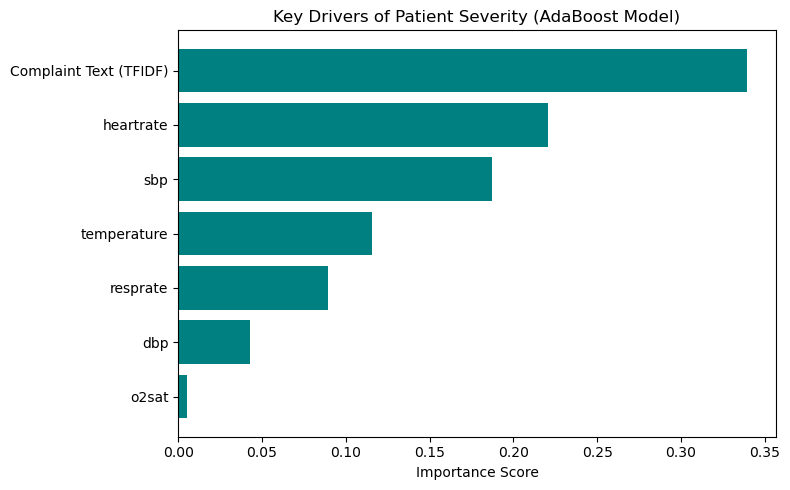

In [44]:
# Reconstruct full feature names
vital_cols = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
feature_names = list(tfidf.get_feature_names_out()) + vital_cols

# Confirm counts match
print("TFIDF feature count:", len(tfidf.get_feature_names_out()))
print("Vital feature count:", len(vital_cols))
print("Total feature names:", len(feature_names))
print("Model feature importances:", len(ada.feature_importances_))

assert len(feature_names) == len(ada.feature_importances_), "Feature name and importance length mismatch!"

# Combine into dataframe
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ada.feature_importances_
})

# Separate vitals and tfidf
vitals_df = importances_df[importances_df['Feature'].isin(vital_cols)]
tfidf_df = importances_df[~importances_df['Feature'].isin(vital_cols)]

# Aggregate TFIDF features
tfidf_importance_sum = tfidf_df['Importance'].sum()
tfidf_summary = pd.DataFrame({
    'Feature': ['Complaint Text (TFIDF)'],
    'Importance': [tfidf_importance_sum]
})

# Combine and plot
final_df = pd.concat([vitals_df, tfidf_summary]).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(final_df['Feature'], final_df['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.title('Key Drivers of Patient Severity (AdaBoost Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_cleaned.png', dpi=300)
plt.show()
